### FOBSS Preprocessing Script
---
Notebook for trying first data preprocessing steps

### Selecting relevant part of Ri Jumps 15A Profile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

cur_master = np.loadtxt('../data/fobss_data/data/Ri Jumps 25A/battery/Battery_Current.csv', delimiter=';')
cur_master = cur_master[80000:100000]

cur_inv = np.loadtxt('../data/fobss_data/data/Ri Jumps 25A/inverter/Inverter_Current.csv', delimiter=';')
cur_inv = cur_inv[:350000]

volt_slave_0_cell_4 = np.loadtxt('../data/fobss_data/data/Ri Jumps 25A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
volt_slave_0_cell_4 = volt_slave_0_cell_4[80000:100000]

In [ ]:
plt.plot(cur_master[:,1]) 
cur_master.shape

In [ ]:
plt.plot(volt_slave_0_cell_4[:,4])
volt_slave_0_cell_4.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

cur_master = np.loadtxt('../data/fobss_data/data/Profile 10A/battery/Battery_Current.csv', delimiter=';')
cur_master = cur_master[500:1000]

volt_slave_0_cell_4 = np.loadtxt('../data/fobss_data/data/Profile 10A/cells/Slave_0_Cell_Voltages.csv', delimiter=';')
volt_slave_0_cell_4 = volt_slave_0_cell_4[500:1000]

In [ ]:
plt.plot(cur_master[:,1]) 
cur_master.shape

In [ ]:
plt.plot(volt_slave_0_cell_4[:,4])
volt_slave_0_cell_4.shape

### Data Subsample Function

In [106]:
def subsample(sequence, d_t):

    subsampled_sequence = np.array([])

    for i in range(0, len(sequence), d_t - 1) :
        
        if len(sequence) < i + d_t:
            # check if at end of sequence
            window = sequence[i:len(sequence)]
        else:
            window = sequence[i:i + d_t]
        
        uniqw, inverse = np.unique(window, return_inverse=True)

        frequent_element_index = np.bincount(inverse).argmax()
        frequent_element = window[frequent_element_index]
        
        subsampled_sequence = np.append(subsampled_sequence, frequent_element)
        
    return subsampled_sequence

In [107]:
test = subsample(volt_slave_0_cell_4[:,1], 50)

(11,)

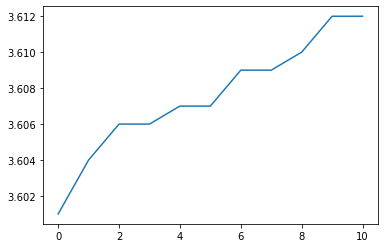

In [108]:
plt.plot(test)
test.shape